This notebook assumes you are using sims_maf version >= 1.1, and have 'setup sims_maf' in your shell. 

This notebooks demonstrates the most commonly used slicers and their features.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler

There are three main slicers that we use in MAF.  For all three, we'll use the same metric and sql query to see how they differ.

Each slicer subdivides and groups the visits from opsim in different ways. 
* The Unislicer simply clumps all visits into one group. 
* The OneDSlicer groups visits into subsets based on the value of a single parameter from the opsim data.
* The HealpixSlicer groups visits into subsets based on whether or not they overlap a given healpixel. 

Each slicer iterates through its set of "slicePoints" - the OneDSlicer iterates through the values of the opsim parameter (in bins) and the HealpixSlicer iterates through all pixels in the healpix grid. At each slicePoint, the metric value is calculated, resulting in a metric data array with as many values as the slicer had slicePoints. 

In [3]:
# Set the database and query
database = 'enigma_1189_sqlite.db'
sqlWhere = 'filter = "r" and night < 400'
opsdb = db.OpsimDatabase(database)
outDir = 'slicers_test'
resultsDb = db.ResultsDb(outDir=outDir)

# For the count metric the col kwarg is pretty much irrelevant, so we'll just use expMJD, but any column in the database would work
metric = metrics.CountMetric(col='expMJD', metricName='Count')


First the UniSlicer--this slicer simply passes all the data directly to the metric. So in this case, we will get the total number of visits.

In [4]:
slicer = slicers.UniSlicer()

In [5]:
bundles = {}
bundles['uni'] = metricBundles.MetricBundle(metric,slicer,sqlWhere)

Next, the oneDSlicer. Here, we say we want to bin based on the 'night' column, and use binsize of 10 (days).  

In [6]:
slicer = slicers.OneDSlicer(sliceColName='night', binsize=10)
bundles['oneD'] = metricBundles.MetricBundle(metric,slicer,sqlWhere)

Finally, the healpixSlicer will calculate the metric at a series of points accross the sky, using only the pointings that overlap the given point.

In [7]:
slicer = slicers.HealpixSlicer(nside=64)
bundles['healpix'] = metricBundles.MetricBundle(metric,slicer,sqlWhere)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [8]:
bgroup = metricBundles.MetricBundleGroup(bundles,opsdb, outDir=outDir, resultsDb=resultsDb)

Now we can run all three and see the output

In [9]:
bgroup.runAll()
bgroup.plotAll()

Querying database with constraint filter = "r" and night < 400
Found 46128 visits
Running:  ['uni']
Completed metric generation.
Running:  ['healpix']
Completed metric generation.

/Users/lynnej/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3758: SAWarning: Textual SQL expression 'filter = "r" and night < ...' should be explicitly declared as text('filter = "r" and night < ...') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})
Optimal bin calculation tried to make 586 bins, returning 200



Running:  ['oneD']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 14.2282  dipole: lon: 57.0805, lat: -76.726, amp: 7.76403
Plotting complete.


Let's examine the results from each slicer a bit further. 

In [10]:
print bundles['uni'].metricValues
bundles['uni'].plot()

[46128.0]


{}

With the UniSlicer, note the metric value matches the output (number of visits) from when we executed bgroup.runAll().  Since the UniSlicer only computes a single value, the plot method returns nothing.

---

[-- 64.0 779.0 20.0 1384.0 713.0 20.0 1352.0 867.0 78.0 20.0 1875.0 857.0
 1406.0 533.0 1283.0 971.0 245.0 1533.0 2520.0 1918.0 2025.0 991.0 61.0
 1401.0 979.0 489.0 643.0 3071.0 811.0 440.0 1930.0 20.0 1032.0 3162.0
 680.0 1420.0 1678.0 2109.0 1459.0 3289.0 --]


{'BinnedData': 1}

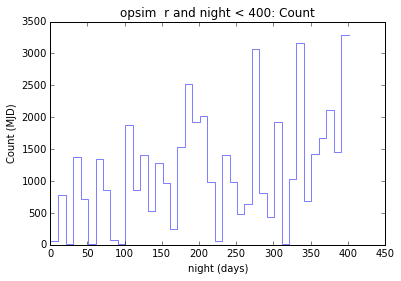

In [11]:
print bundles['oneD'].metricValues
bundles['oneD'].plot()

With the OneDSlicer, we binned on the 'night' value in opsim, and counted how many visits we had in each bin. The metric values show how many visits were in each bin, and the plot method produces a plot of the metric results as a function of the slicer bin values.

---

[-- -- -- ..., 30.0 30.0 60.0]
monopole: 14.2282  dipole: lon: 57.0805, lat: -76.726, amp: 7.76403


Optimal bin calculation tried to make 586 bins, returning 200


{'Histogram': 2, 'PowerSpectrum': 3, 'SkyMap': 1}

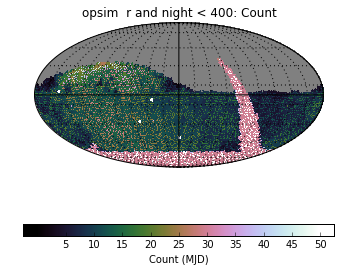

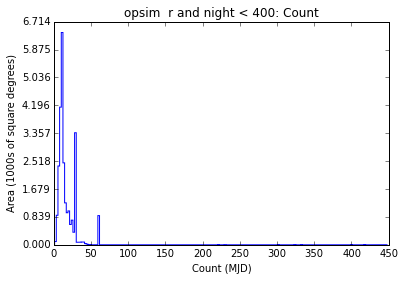

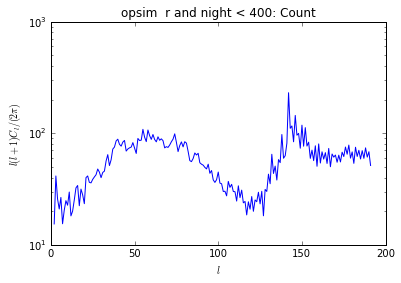

In [18]:
print bundles['healpix'].metricValues
bundles['healpix'].setPlotDict({'colorMin':0, 'colorMax':50})
bundles['healpix'].plot()

With the HealpixSlicer, we calculate the number of visits at each point in the Healpix grid, so we have a long metric data array. We also have three ways to visualize the data; the skymap, a histogram (scaled by the area of each healpixel), and the angular power spectrum of the metric values. 

---